**Perplexity**

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import pandas as pd
import json
from tqdm import tqdm
import logging
import gc
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Force CPU usage
device = torch.device("cpu")
logger.info("Using CPU for computation")

try:
    # Load model & tokenizer
    model_id = "gpt2"
    logger.info(f"Loading model {model_id}...")
    model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
    tokenizer = GPT2TokenizerFast.from_pretrained(model_id)
    model.eval()

    def calculate_perplexity(text, max_length=512):
        if not isinstance(text, str):
            return None
        try:
            inputs = tokenizer(
                text, 
                return_tensors="pt", 
                truncation=True, 
                max_length=max_length
            ).to(device)
            
            with torch.no_grad():
                outputs = model(**inputs, labels=inputs["input_ids"])
                
            return torch.exp(outputs.loss).item()
        except Exception as e:
            logger.warning(f"Error calculating perplexity: {str(e)}")
            return None
        finally:
            # Clean up tensors
            if 'inputs' in locals():
                del inputs
            if 'outputs' in locals():
                del outputs
            gc.collect()

    # Load and process Singapore queries data
    logger.info("Loading Singapore queries data...")
    # Read Excel file into DataFrame
    df = pd.read_csv('query_responses_persona.csv')
    
    # Calculate perplexity with progress bar
    logger.info("Calculating perplexity scores...")
    tqdm.pandas(desc="Processing")
    df['perplexity_raw'] = df['Raw_Response'].progress_apply(calculate_perplexity)
    df['perplexity_struc'] = df['SQ_Response'].progress_apply(calculate_perplexity)
    
    # Remove any None values and show statistics
    df = df.dropna(subset=['perplexity_raw', 'perplexity_struc'])
    logger.info(f"\nRaw Query Perplexity statistics:\n{df['perplexity_raw'].describe()}")
    logger.info(f"\nStructured Query Perplexity statistics:\n{df['perplexity_struc'].describe()}")
    
    # Save results
    output_file = "merged_output_with_perplexity.csv"
    df.to_csv(output_file, index=False)
    logger.info(f"Results saved to {output_file}")
    

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise
finally:
    # Final cleanup
    gc.collect()


INFO:__main__:Using CPU for computation
INFO:__main__:Loading model gpt2...
INFO:__main__:Loading Singapore queries data...
INFO:__main__:Calculating perplexity scores...
Processing: 100%|██████████████████████████████████████████████████████████████████████| 99/99 [01:23<00:00,  1.18it/s]
INFO:__main__:
Raw Query Perplexity statistics:
count     99.000000
mean      18.139206
std       15.017413
min        3.624984
25%       13.831602
50%       13.831602
75%       14.267575
max      114.400841
Name: perplexity_raw, dtype: float64
INFO:__main__:
Structured Query Perplexity statistics:
count    99.000000
mean     12.620250
std       4.157986
min       4.228827
25%       9.835039
50%      11.910451
75%      15.970609
max      21.904036
Name: perplexity_struc, dtype: float64
INFO:__main__:Results saved to merged_output_with_perplexity.csv


In [2]:
df

,Raw_Query,Structural_Query,Raw_Response,SQ_Response,Persona,perplexity_raw,perplexity_struc
0,We're a family of 4 with two children aged 6 a...,You are a highly experienced travel expert and...,Certainly! Here's a suggested itinerary for yo...,"Absolutely, I'd be delighted to help you plan ...",Adventure Seeker;Family Traveler,6.176893,11.564851
1,My husband and I (both 65+) are visiting Singa...,You are a highly experienced travel expert and...,"Based on the information provided, here are so...",Certainly! Here’s a tailored itinerary for you...,Culture Explorer,12.933701,10.804389
2,We're 6 young adults (25-30) staying in Singap...,You are a highly experienced travel expert and...,"For your 6-day stay in Singapore, we've curate...","Absolutely, I'd be delighted to help you plan ...",Adventure Seeker;Family Traveler,9.231961,9.448345
3,Three colleagues extending our business trip f...,You are a highly experienced travel expert and...,"Based on the context provided, here are some a...",Certainly! Here's a tailored itinerary for you...,Family Traveler;Solo Traveler,12.280449,8.197965
4,We're a group of 8 spanning three generations ...,You are a highly experienced travel expert and...,"Based on the context provided, here is a plan ...",Here's a tailored itinerary for your family tr...,Family Traveler,4.099358,8.238830
...,...,...,...,...,...,...,...
94,"A family of four with two kids, join local eve...",You are a highly experienced travel expert and...,I don't have enough information to answer this...,"For your family trip to Singapore, here's a we...",Family Traveler;Foodie,13.831602,8.258045
95,"My partner and I, plan a relaxing trip in Sing...",You are a highly experienced travel expert and...,"Based on the information provided, here is a s...","For your relaxing trip in Singapore next week,...",Backpacker;Family Traveler;Solo Traveler,20.985163,10.567276
96,"We want a wellness retreat, plan a relaxing tr...",You are a highly experienced travel expert and...,I don't have enough information to answer this...,"For a relaxing weekend in Singapore, focusing ...",Luxury Seeker;Relaxation Seeker,13.831602,13.159389
97,"We want a wellness retreat, attend an art fest...",You are a highly experienced travel expert and...,I don't have enough information to answer this...,Certainly! Here's a tailored itinerary for you...,Luxury Seeker;Relaxation Seeker,13.831602,10.825290


In [3]:
# Split the rows based on Persona column
# First, explode the Persona column after splitting by ';'
df_exploded = df.assign(Persona=df['Persona'].str.split(';')).explode('Persona')

# Clean up any leading/trailing whitespace in the Persona column
df_exploded['Persona'] = df_exploded['Persona'].str.strip()

# Reset the index to have clean consecutive numbers
df_exploded = df_exploded.reset_index(drop=True)

In [4]:
# Display the first few rows to verify the split
df_exploded

,Raw_Query,Structural_Query,Raw_Response,SQ_Response,Persona,perplexity_raw,perplexity_struc
0,We're a family of 4 with two children aged 6 a...,You are a highly experienced travel expert and...,Certainly! Here's a suggested itinerary for yo...,"Absolutely, I'd be delighted to help you plan ...",Adventure Seeker,6.176893,11.564851
1,We're a family of 4 with two children aged 6 a...,You are a highly experienced travel expert and...,Certainly! Here's a suggested itinerary for yo...,"Absolutely, I'd be delighted to help you plan ...",Family Traveler,6.176893,11.564851
2,My husband and I (both 65+) are visiting Singa...,You are a highly experienced travel expert and...,"Based on the information provided, here are so...",Certainly! Here’s a tailored itinerary for you...,Culture Explorer,12.933701,10.804389
3,We're 6 young adults (25-30) staying in Singap...,You are a highly experienced travel expert and...,"For your 6-day stay in Singapore, we've curate...","Absolutely, I'd be delighted to help you plan ...",Adventure Seeker,9.231961,9.448345
4,We're 6 young adults (25-30) staying in Singap...,You are a highly experienced travel expert and...,"For your 6-day stay in Singapore, we've curate...","Absolutely, I'd be delighted to help you plan ...",Family Traveler,9.231961,9.448345
...,...,...,...,...,...,...,...
181,"We want a wellness retreat, plan a relaxing tr...",You are a highly experienced travel expert and...,I don't have enough information to answer this...,"For a relaxing weekend in Singapore, focusing ...",Luxury Seeker,13.831602,13.159389
182,"We want a wellness retreat, plan a relaxing tr...",You are a highly experienced travel expert and...,I don't have enough information to answer this...,"For a relaxing weekend in Singapore, focusing ...",Relaxation Seeker,13.831602,13.159389
183,"We want a wellness retreat, attend an art fest...",You are a highly experienced travel expert and...,I don't have enough information to answer this...,Certainly! Here's a tailored itinerary for you...,Luxury Seeker,13.831602,10.825290
184,"We want a wellness retreat, attend an art fest...",You are a highly experienced travel expert and...,I don't have enough information to answer this...,Certainly! Here's a tailored itinerary for you...,Relaxation Seeker,13.831602,10.825290


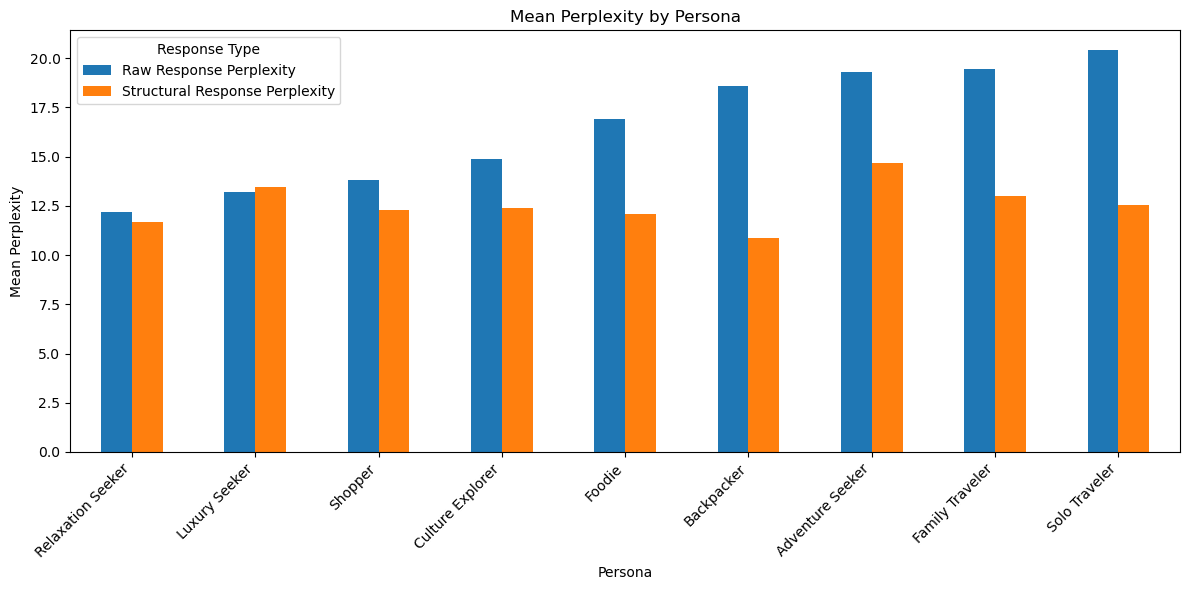

In [5]:
import matplotlib.pyplot as plt

# Group by Persona and calculate mean perplexity for each
persona_perplexity = df_exploded.groupby('Persona')[['perplexity_raw', 'perplexity_struc']].mean().sort_values('perplexity_raw')

# Rename columns for legend
persona_perplexity = persona_perplexity.rename(columns={
    'perplexity_raw': 'Raw Response Perplexity',
    'perplexity_struc': 'Structural Response Perplexity'
})

# Plot
ax = persona_perplexity.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Mean Perplexity')
plt.title('Mean Perplexity by Persona')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Response Type')
plt.show()